<a href="https://colab.research.google.com/github/mandar33/BI-LSTM-CRF-FC/blob/main/CS598BIDIR-LISTM-CRF-STACKED-Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import numpy as np
import random
import math
from tqdm import tqdm
import os
import re
import io


In [2]:
class dictionary():
    def __init__(self):
        self.word_freq={}
        self.id2word={}
        self.word2id={}
    
    def add_word(self,word):
        if word in self.word_freq:
            self.word_freq[word]+=1
        else:
            self.word_freq[word]=1
        
    def create_mapping(self):
        self.word_freq['[PAD]']=1000001
        self.word_freq['[UNK]']=1000000
        c_unk=0
        dic_items=[]
        for k in self.word_freq.keys():
            if self.word_freq[k]>1 or np.random.uniform()>0.5:
                dic_items.append((k,self.word_freq[k]))
            else:
                c_unk+=1
        ordered_lis=sorted( dic_items, key=lambda x: (-x[1],x[0]))
        assert ordered_lis[0][0]=='[PAD]'
        self.id2word=dict([(i,ordered_lis[i][0]) for i in range(len(ordered_lis))])
        self.word2id=dict([(ordered_lis[i][0],i) for i in range(len(ordered_lis))])
        self.ordered_lis=ordered_lis
        return c_unk

    def get_id(self,word):
        if word in self.word2id:
            return self.word2id[word]
        else:
            return 1
    
    def get_word(self,idx):
        return self.id2word[idx]
    
    def get_len(self):
        return len(self.id2word)

In [3]:
class I2B2DatasetReader(Dataset):
    def __init__(self,data_path,dic_word,dic_char,training=False):
        super(I2B2DatasetReader,self).__init__()
        f=open(data_path,encoding='utf-8')
        X=[[]]
        Y=[[]]

        line=f.readline()
        self.label_map=["O","B-problem","I-problem","B-test","I-test","B-treatment","I-treatment","B-MISC","I-MISC"]
        self.label_num=len(self.label_map)

        while line:
            if line=='\n':
                if len(X[-1])>0:
                    X.append([])
                    Y.append([])
            else:
                word,ner=line.split()
                assert ner in self.label_map
                word=re.sub('\d','0',word)      #replace all the digits with 0, this helps
                X[-1].append(word)
                Y[-1].append(self.label_map.index(ner))
            line=f.readline()
                
        f.close()
        if len(X[-1])==0:
            X=X[:-1]
            Y=Y[:-1]

        self.label=Y
        self.data_num=len(X)

        #get word dictionary
        if training:
            dic_word=dictionary()
            for sentence in X:
                for word in sentence:
                    dic_word.add_word(word)
            dic_word.create_mapping()

        #get word_ids: list of lists
        #encode words str->id
        self.word_ids=[]
        for i in range(len(X)):
            self.word_ids.append(list(map(lambda x:dic_word.get_id(x), X[i])))

        #get character dictionary
        if training:
            dic_char=dictionary()
            for sentence in X:
                text=''.join(sentence)
                for char in text:
                    dic_char.add_word(char)
            dic_char.create_mapping()

        #get char_ids: list of lists of lists
        self.char_ids=[]
        for sentence in X:
            s=[]
            for word in sentence:
                s.append(list(map(lambda x:dic_char.get_id(x), word)))
            self.char_ids.append(s)

        self.dic_word=dic_word
        self.dic_char=dic_char

    def __getitem__(self,index):
        return self.word_ids[index],self.char_ids[index],self.label[index]

    def __len__(self):
        return self.data_num
     



In [4]:
def augment_vocab(dictionary,embedding_path,paths):
            f=open(embedding_path,encoding="utf-8")
            line=f.readline()
            word2emb={}
            while line:
                line=line.split()
                word2emb[line[0]]=torch.from_numpy(np.array(line[1:],dtype=np.str).astype(np.float))
                line=f.readline()

            words=[]
            for data_path in paths:
                f=open(data_path,encoding='utf-8')
                line=f.readline()
                while line:
                    if line=='\n':
                        pass
                    else:
                        word=line.split()[0]
                        words.append(word)
                    line=f.readline()
                f.close()

            train_len=dictionary.get_len()
            for word in words:
                if word not in dictionary.word2id and any([x in word2emb for x in [word,word.lower(),re.sub('\d','0',word.lower())]]):
                    dictionary.word2id[word]=dictionary.get_len()
                    dictionary.id2word[dictionary.get_len()]=word
                    dictionary.ordered_lis.append((word,0))
            num_add=dictionary.get_len()-train_len
            print("original word num: %d  expand num: %d"%(train_len,num_add)) 
            return dictionary,word2emb

def collate_batch(batch):
            #input is a list of tuples
            word_num=list(map(lambda x:len(x[0]),batch))
            max_word_num=max(word_num)
            word_ids=list(map(lambda x:x[0]+[0]*(max_word_num-len(x[0])),batch))
            label_ids=list(map(lambda x:x[2]+[0]*(max_word_num-len(x[2])),batch))

            max_word_length=max(list(map(lambda x:max([len(i) for i in x[1]]),batch)))
            char_ids=[]
            for tuple in batch:
                s=[]
                for word in tuple[1]:
                    s.append(word+[0]*(max_word_length-len(word)))
                s=s+[[0]*max_word_length for i in range((max_word_num-len(s)))]
                char_ids.append(s)

            word_num=torch.LongTensor(word_num)
            word_ids=torch.LongTensor(word_ids)
            char_ids=torch.LongTensor(char_ids)
            label_ids=torch.LongTensor(label_ids)

            return word_num,word_ids,char_ids,label_ids

def forward_alg(observation,transition,word_num):

            def log_sum_exp(matrix,dim):
                maximum,_=matrix.max(dim=dim,keepdim=True)  #to avoid NaN
                return (maximum+torch.log(torch.exp(matrix-maximum).sum(dim=dim,keepdim=True))).squeeze(1)

            observation=observation.transpose(1,2)
            transition=transition.unsqueeze(0).expand(observation.size(0),-1,-1)
            alpha=torch.zeros_like(observation)
            alpha[:,:,0:1]=observation[:,:,0:1]
            for i in range(1,observation.size(2)):
                alpha[:,:,i:i+1]=(observation[:,:,i]+log_sum_exp(alpha[:,:,i-1:i]+transition,dim=1)).unsqueeze(2)
            end_label=alpha[:,10,1:]     #(batch_size, sequence_len)
            return end_label.gather(1,word_num.unsqueeze(1)).squeeze(1)

def list_batch(pred,word_num,word_ids,label_ids,dic_word,label_map):
    pred=pred.tolist()
    word_num=word_num.tolist()
    label_ids=label_ids.tolist()
    word_ids=word_ids.tolist()

    outputs=[]
    for i in range(len(word_num)):
        seq_len=word_num[i]
        prediction=pred[i][:seq_len]
        target=label_ids[i][:seq_len]
        words=word_ids[i][:seq_len]
        prediction=list(map(lambda x: label_map[x], prediction))
        target=list(map(lambda x: label_map[x], target))
        words=list(map(lambda x: dic_word.get_word(x), words))
        for j in range(seq_len):
            outputs.append(' '.join([words[j],target[j],prediction[j]]))
        outputs.append('')
    
    return outputs  

In [5]:
class LSTM_CRF(nn.Module):
    def __init__(self,word2emb,dic_word,dic_char):
        super(LSTM_CRF, self).__init__()
        word_emb_dim=300
        word_lstm_dim=300
        char_emb_dim=25
        char_lstm_dim=25
        label_num=9
        dropout_rate=0.4
            
        word_emb=nn.Embedding(dic_word.get_len(),word_emb_dim,padding_idx=0)
        for i in range(dic_word.get_len()):
            word=dic_word.ordered_lis[i][0]
            if word in word2emb:
                word_emb.weight.data[i]=word2emb[word]
            elif word.lower() in word2emb:
                word_emb.weight.data[i]=word2emb[word.lower()]
            elif re.sub('\d','0',word.lower()) in word2emb:
                word_emb.weight.data[i]=word2emb[re.sub('\d','0',word.lower())]
        #print(word_emb.weight.data[0])


        char_emb=nn.Embedding(dic_char.get_len(),char_emb_dim,padding_idx=0)

        self.char_emb=char_emb
        self.char_lstm=nn.LSTM(char_emb_dim,char_lstm_dim,num_layers = 4,batch_first=True,bidirectional=True)
        self.word_emb=word_emb
        self.dropout=nn.Dropout(dropout_rate)
        self.word_lstm=nn.LSTM(word_emb_dim+char_lstm_dim*2, word_lstm_dim,batch_first=True,num_layers = 4,bidirectional=True)      
        self.fc=  nn.Linear((word_emb_dim)*2,label_num)

        #crf
        self.transition=nn.Parameter(torch.full((label_num+2,label_num+2),math.log(1/label_num)))
        
        self.char_lstm_dim=char_lstm_dim
        self.char_emb_dim=char_emb_dim
        self.word_lstm_dim=word_lstm_dim
        self.word_emb_dim=word_emb_dim
        self.label_num=label_num
        
    def get_feature(self,word_num,word_ids,char_ids):
        batch_size=word_ids.size(0)
        sequence_len=word_ids.size(1)
        char_input=self.char_emb(char_ids)
        #print(char_input.size())    #4 dimensional
        char_emb_dim=char_input.size(3)
        word_len=char_input.size(2)
        char_input=char_input.view(batch_size*sequence_len,word_len,char_emb_dim)
        char_hidden,_=self.char_lstm(char_input)    #second output "_" is equal to char_output below
        forward_=char_hidden[:,-1,:self.char_lstm_dim]
        backward_=char_hidden[:,0,self.char_lstm_dim:]
        char_output=torch.cat((forward_,backward_),dim=-1)
        char_output=char_output.view(batch_size,sequence_len,self.char_lstm_dim*2)

        index=torch.LongTensor(list(range(sequence_len))).cuda().unsqueeze(0).expand(batch_size,sequence_len)
        condition=word_num.unsqueeze(1).expand(batch_size,sequence_len)>index
        mask=torch.where(condition,torch.ones(1,).cuda(),torch.zeros(1,).cuda()).unsqueeze(2)
        char_output*=mask   #to mask all the padding tokens

        word_feature=self.word_emb(word_ids)
        word_feature=torch.cat((word_feature,char_output),dim=-1)
        word_feature=self.dropout(word_feature)
        word_feature,_=self.word_lstm(word_feature)

        #word_feature=self.hidden(word_feature)
        word_feature = self.fc(word_feature)
        
        word_feature*=mask
      
        return word_feature,mask
    
    def forward(self,word_num,word_ids,char_ids,label_ids):    
        batch_size=word_ids.size(0)
        sequence_len=word_ids.size(1)
        word_feature,mask=self.get_feature(word_num,word_ids,char_ids)
        
        #compute numerator: the score of target label sequence
        numerator=word_feature.gather(2,label_ids.unsqueeze(2)).squeeze(2).sum(dim=1)
        #print(numerator.size())
        padded_label=torch.cat((torch.full((batch_size,1),9,dtype=torch.long).cuda(), label_ids), dim=1)

        #print(self.transition[(padded_label[:,:-1],padded_label[:,1:])].size()) 
        #a tensor can be indexed by several LongTensors or lists, each of them corresponds with an axis
        trans_score=self.transition[(padded_label[:,:-1],padded_label[:,1:])]   #size(batch_size,sequence_len)
        trans_score*=mask.squeeze(2)
        numerator+=trans_score.sum(dim=1)
        last_label=(padded_label.gather(1,word_num.unsqueeze(1))).squeeze()
        numerator+=self.transition[(last_label,torch.full((batch_size,),10,dtype=torch.long).cuda())]
        
        #prepare observation matrix
        small=-1000
        se_label=torch.full((batch_size,sequence_len,2),small,dtype=torch.float).cuda()*mask
        observation=torch.cat((word_feature,se_label),dim=2)
        observation=torch.cat((torch.full((batch_size,1,self.label_num+2),small,dtype=torch.float).cuda(),
                                observation,
                                torch.full((batch_size,1,self.label_num+2),small,dtype=torch.float).cuda()),dim=1)
        
       
      

        observation[:,0,9]=0
        observation[:,-1,10]=0

        denominator=forward_alg(observation,self.transition,word_num)   #the score of all the label sequences
        loss=-(numerator-denominator)

        return torch.mean(loss)
    
    def decode(self,word_num,word_ids,char_ids):
        batch_size=word_ids.size(0)
        sequence_len=word_ids.size(1)
        word_feature,mask=self.get_feature(word_num,word_ids,char_ids)

        index=torch.LongTensor(list(range(sequence_len))).cuda().unsqueeze(0).expand(batch_size,sequence_len)
        condition=word_num.unsqueeze(1).expand(batch_size,sequence_len)==index
        end_mask=torch.where(condition,torch.ones(1,).cuda(),torch.zeros(1,).cuda()).unsqueeze(2)

        small=-1000
        constrain=torch.full((batch_size,sequence_len,self.label_num+2),small,dtype=torch.float).cuda()*end_mask
        constrain[:,:,10]=0         #tensor "constrain" is used to make sure all the paths finish at [END] state

        se_label=torch.full((batch_size,sequence_len,2),small,dtype=torch.float).cuda()*mask    #correspond with Start and End label
        observation=torch.cat((word_feature,se_label),dim=2)
        observation+=constrain
        observation=torch.cat((torch.full((batch_size,1,self.label_num+2),small,dtype=torch.float).cuda(),
                                observation,
                                torch.full((batch_size,1,self.label_num+2),small,dtype=torch.float).cuda()),dim=1)
        observation[:,0,9]=0
        observation[:,-1,10]=0
        
        #viterbi
        observation=observation.transpose(1,2)
        path=torch.zeros_like(observation).long().cuda()
        transition=self.transition.unsqueeze(0).expand(batch_size,-1,-1)
        z=observation[:,:,0:1]
        for i in range(1,observation.size(2)):
            values,indices=(z+transition).max(dim=1)
            path[:,:,i]=indices
            values+=observation[:,:,i]
            z=values.unsqueeze(2)

        last=path[:,10,-1:]
        pred=last
        for i in range(path.size(2)-2,1,-1):
            last=path[:,:,i].gather(1,last)
            pred=torch.cat((last,pred),dim=1)   
        
        #pred size: batch_size,sequence_len
        #print(pred.size())

        #validation     this step is unnecessary, just make sure there is nothing wrong
        pred_=torch.cat((pred,torch.full((batch_size,1),10,dtype=torch.long).cuda()),dim=1)
        condition=pred_.gather(1,word_num.unsqueeze(1)).squeeze(1)==10
        assert condition.size(0)==(condition.sum().item())
        #print("validation passed")

        return pred


In [6]:
pip install conlleval

In [7]:
import re


import matplotlib.pyplot as plt

def my_plot(epochs, datalist):
    plt.plot(epochs, datalist)
    # Add title and axis names
    #legend = plt.legend(loc='upper right')
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


original word num: 7732  expand num: 2401


100%|██████████| 183/183 [00:18<00:00,  9.82it/s]


epoch 0:  mean loss: 6.1231  f1 score: 50.48  best: 50.48


100%|██████████| 183/183 [00:18<00:00,  9.86it/s]


epoch 1:  mean loss: 2.6180  f1 score: 70.94  best: 70.94


100%|██████████| 183/183 [00:18<00:00,  9.68it/s]


epoch 2:  mean loss: 1.7086  f1 score: 75.21  best: 75.21


100%|██████████| 183/183 [00:18<00:00,  9.64it/s]


epoch 3:  mean loss: 1.2489  f1 score: 77.54  best: 77.54


100%|██████████| 183/183 [00:19<00:00,  9.47it/s]


epoch 4:  mean loss: 0.9415  f1 score: 78.12  best: 78.12


100%|██████████| 183/183 [00:19<00:00,  9.61it/s]


epoch 5:  mean loss: 0.7612  f1 score: 79.11  best: 79.11


100%|██████████| 183/183 [00:19<00:00,  9.55it/s]


epoch 6:  mean loss: 0.6253  f1 score: 79.57  best: 79.57


100%|██████████| 183/183 [00:19<00:00,  9.60it/s]


epoch 7:  mean loss: 0.5253  f1 score: 79.21  best: 79.57


100%|██████████| 183/183 [00:19<00:00,  9.46it/s]


epoch 8:  mean loss: 0.4337  f1 score: 78.55  best: 79.57


100%|██████████| 183/183 [00:19<00:00,  9.55it/s]


epoch 9:  mean loss: 0.3870  f1 score: 79.63  best: 79.63


100%|██████████| 183/183 [00:19<00:00,  9.58it/s]


epoch 10:  mean loss: 0.2963  f1 score: 79.10  best: 79.63


100%|██████████| 183/183 [00:18<00:00,  9.65it/s]


epoch 11:  mean loss: 0.2533  f1 score: 80.08  best: 80.08


100%|██████████| 183/183 [00:19<00:00,  9.48it/s]


epoch 12:  mean loss: 0.2124  f1 score: 79.71  best: 80.08


100%|██████████| 183/183 [00:19<00:00,  9.39it/s]


epoch 13:  mean loss: 0.2083  f1 score: 79.45  best: 80.08


100%|██████████| 183/183 [00:18<00:00,  9.71it/s]


epoch 14:  mean loss: 0.1804  f1 score: 80.31  best: 80.31


100%|██████████| 183/183 [00:19<00:00,  9.50it/s]


epoch 15:  mean loss: 0.1589  f1 score: 80.17  best: 80.31


100%|██████████| 183/183 [00:18<00:00,  9.66it/s]


epoch 16:  mean loss: 0.1476  f1 score: 79.30  best: 80.31


100%|██████████| 183/183 [00:19<00:00,  9.62it/s]


epoch 17:  mean loss: 0.1509  f1 score: 80.20  best: 80.31


100%|██████████| 183/183 [00:19<00:00,  9.61it/s]


epoch 18:  mean loss: 0.1264  f1 score: 80.13  best: 80.31


100%|██████████| 183/183 [00:19<00:00,  9.56it/s]


epoch 19:  mean loss: 0.1251  f1 score: 79.85  best: 80.31


100%|██████████| 183/183 [00:20<00:00,  8.98it/s]


epoch 20:  mean loss: 0.1224  f1 score: 80.04  best: 80.31


100%|██████████| 183/183 [00:19<00:00,  9.62it/s]


epoch 21:  mean loss: 0.1364  f1 score: 78.92  best: 80.31


100%|██████████| 183/183 [00:19<00:00,  9.61it/s]


epoch 22:  mean loss: 0.1066  f1 score: 79.66  best: 80.31


100%|██████████| 183/183 [00:19<00:00,  9.38it/s]


epoch 23:  mean loss: 0.0873  f1 score: 80.40  best: 80.40


100%|██████████| 183/183 [00:19<00:00,  9.54it/s]


epoch 24:  mean loss: 0.0903  f1 score: 79.29  best: 80.40


100%|██████████| 183/183 [00:19<00:00,  9.50it/s]


epoch 25:  mean loss: 0.0771  f1 score: 80.49  best: 80.49


100%|██████████| 183/183 [00:19<00:00,  9.62it/s]


epoch 26:  mean loss: 0.0866  f1 score: 79.49  best: 80.49


100%|██████████| 183/183 [00:19<00:00,  9.56it/s]


epoch 27:  mean loss: 0.0643  f1 score: 80.11  best: 80.49


100%|██████████| 183/183 [00:19<00:00,  9.49it/s]


epoch 28:  mean loss: 0.0665  f1 score: 80.91  best: 80.91


100%|██████████| 183/183 [00:19<00:00,  9.50it/s]


epoch 29:  mean loss: 0.0793  f1 score: 80.49  best: 80.91


100%|██████████| 183/183 [00:19<00:00,  9.48it/s]


epoch 30:  mean loss: 0.0584  f1 score: 80.90  best: 80.91


100%|██████████| 183/183 [00:19<00:00,  9.43it/s]


epoch 31:  mean loss: 0.0534  f1 score: 80.91  best: 80.91


100%|██████████| 183/183 [00:19<00:00,  9.53it/s]


epoch 32:  mean loss: 0.0504  f1 score: 81.03  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.43it/s]


epoch 33:  mean loss: 0.0659  f1 score: 80.65  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.51it/s]


epoch 34:  mean loss: 0.0653  f1 score: 80.54  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.53it/s]


epoch 35:  mean loss: 0.0618  f1 score: 80.12  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.43it/s]


epoch 36:  mean loss: 0.0421  f1 score: 80.12  best: 81.03


100%|██████████| 183/183 [00:18<00:00,  9.70it/s]


epoch 37:  mean loss: 0.0697  f1 score: 79.19  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.41it/s]


epoch 38:  mean loss: 0.0520  f1 score: 79.68  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.53it/s]


epoch 39:  mean loss: 0.0549  f1 score: 79.32  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.38it/s]


epoch 40:  mean loss: 0.0434  f1 score: 79.09  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.54it/s]


epoch 41:  mean loss: 0.0478  f1 score: 79.42  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.42it/s]


epoch 42:  mean loss: 0.0514  f1 score: 79.88  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.47it/s]


epoch 43:  mean loss: 0.0479  f1 score: 80.19  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.56it/s]


epoch 44:  mean loss: 0.0404  f1 score: 80.31  best: 81.03


100%|██████████| 183/183 [00:18<00:00,  9.65it/s]


epoch 45:  mean loss: 0.0378  f1 score: 79.59  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.37it/s]


epoch 46:  mean loss: 0.0421  f1 score: 79.47  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.57it/s]


epoch 47:  mean loss: 0.0501  f1 score: 79.34  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.56it/s]


epoch 48:  mean loss: 0.0389  f1 score: 80.23  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.57it/s]


epoch 49:  mean loss: 0.0360  f1 score: 79.87  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.44it/s]


epoch 50:  mean loss: 0.0395  f1 score: 79.28  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.43it/s]


epoch 51:  mean loss: 0.0392  f1 score: 79.63  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.56it/s]


epoch 52:  mean loss: 0.0449  f1 score: 78.58  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.49it/s]


epoch 53:  mean loss: 0.0445  f1 score: 80.45  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.48it/s]


epoch 54:  mean loss: 0.0323  f1 score: 80.74  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.59it/s]


epoch 55:  mean loss: 0.0287  f1 score: 80.43  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.52it/s]


epoch 56:  mean loss: 0.0275  f1 score: 81.00  best: 81.03


100%|██████████| 183/183 [00:20<00:00,  9.06it/s]


epoch 57:  mean loss: 0.0299  f1 score: 80.99  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.62it/s]


epoch 58:  mean loss: 0.0329  f1 score: 80.23  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.41it/s]


epoch 59:  mean loss: 0.0354  f1 score: 80.16  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.58it/s]


epoch 60:  mean loss: 0.0320  f1 score: 79.48  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.52it/s]


epoch 61:  mean loss: 0.0376  f1 score: 80.35  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.52it/s]


epoch 62:  mean loss: 0.0248  f1 score: 80.22  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.53it/s]


epoch 63:  mean loss: 0.0319  f1 score: 80.80  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.45it/s]


epoch 64:  mean loss: 0.0298  f1 score: 80.45  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.50it/s]


epoch 65:  mean loss: 0.0287  f1 score: 80.05  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.54it/s]


epoch 66:  mean loss: 0.0261  f1 score: 81.00  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.47it/s]


epoch 67:  mean loss: 0.0283  f1 score: 80.57  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.63it/s]


epoch 68:  mean loss: 0.0330  f1 score: 80.71  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.51it/s]


epoch 69:  mean loss: 0.0227  f1 score: 80.37  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.52it/s]


epoch 70:  mean loss: 0.0309  f1 score: 80.66  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.42it/s]


epoch 71:  mean loss: 0.0302  f1 score: 80.42  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.39it/s]


epoch 72:  mean loss: 0.0311  f1 score: 79.28  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.63it/s]


epoch 73:  mean loss: 0.0276  f1 score: 79.98  best: 81.03


100%|██████████| 183/183 [00:18<00:00,  9.64it/s]


epoch 74:  mean loss: 0.0232  f1 score: 79.96  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.58it/s]


epoch 75:  mean loss: 0.0204  f1 score: 79.84  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.53it/s]


epoch 76:  mean loss: 0.0253  f1 score: 80.50  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.49it/s]


epoch 77:  mean loss: 0.0240  f1 score: 80.46  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.42it/s]


epoch 78:  mean loss: 0.0316  f1 score: 80.47  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.41it/s]


epoch 79:  mean loss: 0.0274  f1 score: 79.80  best: 81.03


100%|██████████| 183/183 [00:18<00:00,  9.66it/s]


epoch 80:  mean loss: 0.0259  f1 score: 80.15  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.43it/s]


epoch 81:  mean loss: 0.0297  f1 score: 79.85  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.42it/s]


epoch 82:  mean loss: 0.0262  f1 score: 79.75  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.57it/s]


epoch 83:  mean loss: 0.0222  f1 score: 79.72  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.49it/s]


epoch 84:  mean loss: 0.0243  f1 score: 80.11  best: 81.03


100%|██████████| 183/183 [00:18<00:00,  9.68it/s]


epoch 85:  mean loss: 0.0240  f1 score: 79.72  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.61it/s]


epoch 86:  mean loss: 0.0295  f1 score: 79.91  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.61it/s]


epoch 87:  mean loss: 0.0278  f1 score: 79.93  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.52it/s]


epoch 88:  mean loss: 0.0231  f1 score: 79.89  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.49it/s]


epoch 89:  mean loss: 0.0266  f1 score: 79.52  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.55it/s]


epoch 90:  mean loss: 0.0229  f1 score: 79.83  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.56it/s]


epoch 91:  mean loss: 0.0220  f1 score: 80.43  best: 81.03


100%|██████████| 183/183 [00:18<00:00,  9.69it/s]


epoch 92:  mean loss: 0.0197  f1 score: 79.57  best: 81.03


100%|██████████| 183/183 [00:18<00:00,  9.67it/s]


epoch 93:  mean loss: 0.0198  f1 score: 79.35  best: 81.03


100%|██████████| 183/183 [00:18<00:00,  9.87it/s]


epoch 94:  mean loss: 0.0201  f1 score: 80.46  best: 81.03


100%|██████████| 183/183 [00:18<00:00,  9.67it/s]


epoch 95:  mean loss: 0.0184  f1 score: 80.57  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.60it/s]


epoch 96:  mean loss: 0.0245  f1 score: 79.71  best: 81.03


100%|██████████| 183/183 [00:18<00:00,  9.84it/s]


epoch 97:  mean loss: 0.0239  f1 score: 80.31  best: 81.03


100%|██████████| 183/183 [00:18<00:00,  9.65it/s]


epoch 98:  mean loss: 0.0178  f1 score: 79.50  best: 81.03


100%|██████████| 183/183 [00:18<00:00,  9.71it/s]


epoch 99:  mean loss: 0.0166  f1 score: 80.47  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.56it/s]


epoch 100:  mean loss: 0.0135  f1 score: 80.22  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.60it/s]


epoch 101:  mean loss: 0.0172  f1 score: 80.26  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.60it/s]


epoch 102:  mean loss: 0.0204  f1 score: 80.36  best: 81.03


100%|██████████| 183/183 [00:18<00:00,  9.70it/s]


epoch 103:  mean loss: 0.0251  f1 score: 80.20  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.48it/s]


epoch 104:  mean loss: 0.0226  f1 score: 80.26  best: 81.03


100%|██████████| 183/183 [00:18<00:00,  9.64it/s]


epoch 105:  mean loss: 0.0232  f1 score: 79.89  best: 81.03


100%|██████████| 183/183 [00:18<00:00,  9.75it/s]


epoch 106:  mean loss: 0.0210  f1 score: 79.72  best: 81.03


100%|██████████| 183/183 [00:18<00:00,  9.68it/s]


epoch 107:  mean loss: 0.0270  f1 score: 80.20  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.49it/s]


epoch 108:  mean loss: 0.0189  f1 score: 79.80  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.59it/s]


epoch 109:  mean loss: 0.0238  f1 score: 79.61  best: 81.03


100%|██████████| 183/183 [00:19<00:00,  9.63it/s]


epoch 110:  mean loss: 0.0188  f1 score: 81.04  best: 81.04


100%|██████████| 183/183 [00:19<00:00,  9.49it/s]


epoch 111:  mean loss: 0.0218  f1 score: 80.76  best: 81.04


100%|██████████| 183/183 [00:18<00:00,  9.64it/s]


epoch 112:  mean loss: 0.0194  f1 score: 80.90  best: 81.04


100%|██████████| 183/183 [00:18<00:00,  9.66it/s]


epoch 113:  mean loss: 0.0149  f1 score: 80.19  best: 81.04


100%|██████████| 183/183 [00:18<00:00,  9.69it/s]


epoch 114:  mean loss: 0.0178  f1 score: 80.67  best: 81.04


100%|██████████| 183/183 [00:18<00:00,  9.71it/s]


epoch 115:  mean loss: 0.0187  f1 score: 80.44  best: 81.04


100%|██████████| 183/183 [00:18<00:00,  9.65it/s]


epoch 116:  mean loss: 0.0192  f1 score: 80.09  best: 81.04


100%|██████████| 183/183 [00:18<00:00,  9.64it/s]


epoch 117:  mean loss: 0.0153  f1 score: 80.43  best: 81.04


100%|██████████| 183/183 [00:18<00:00,  9.67it/s]


epoch 118:  mean loss: 0.0178  f1 score: 80.10  best: 81.04


100%|██████████| 183/183 [00:19<00:00,  9.46it/s]


epoch 119:  mean loss: 0.0151  f1 score: 81.10  best: 81.10


100%|██████████| 183/183 [00:18<00:00,  9.68it/s]


epoch 120:  mean loss: 0.0147  f1 score: 80.92  best: 81.10


100%|██████████| 183/183 [00:19<00:00,  9.57it/s]


epoch 121:  mean loss: 0.0174  f1 score: 80.66  best: 81.10


100%|██████████| 183/183 [00:18<00:00,  9.72it/s]


epoch 122:  mean loss: 0.0173  f1 score: 80.60  best: 81.10


100%|██████████| 183/183 [00:18<00:00,  9.65it/s]


epoch 123:  mean loss: 0.0158  f1 score: 80.39  best: 81.10


100%|██████████| 183/183 [00:19<00:00,  9.59it/s]


epoch 124:  mean loss: 0.0165  f1 score: 81.01  best: 81.10


100%|██████████| 183/183 [00:19<00:00,  9.61it/s]


epoch 125:  mean loss: 0.0164  f1 score: 80.34  best: 81.10


100%|██████████| 183/183 [00:18<00:00,  9.76it/s]


epoch 126:  mean loss: 0.0147  f1 score: 80.53  best: 81.10


100%|██████████| 183/183 [00:19<00:00,  9.57it/s]


epoch 127:  mean loss: 0.0179  f1 score: 80.68  best: 81.10


100%|██████████| 183/183 [00:19<00:00,  9.57it/s]


epoch 128:  mean loss: 0.0213  f1 score: 80.71  best: 81.10


100%|██████████| 183/183 [00:19<00:00,  9.61it/s]


epoch 129:  mean loss: 0.0176  f1 score: 80.94  best: 81.10


100%|██████████| 183/183 [00:19<00:00,  9.61it/s]


epoch 130:  mean loss: 0.0170  f1 score: 80.83  best: 81.10


100%|██████████| 183/183 [00:18<00:00,  9.80it/s]


epoch 131:  mean loss: 0.0141  f1 score: 81.22  best: 81.22


100%|██████████| 183/183 [00:18<00:00,  9.75it/s]


epoch 132:  mean loss: 0.0206  f1 score: 81.23  best: 81.23


100%|██████████| 183/183 [00:19<00:00,  9.59it/s]


epoch 133:  mean loss: 0.0177  f1 score: 81.63  best: 81.63


100%|██████████| 183/183 [00:18<00:00,  9.66it/s]


epoch 134:  mean loss: 0.0150  f1 score: 81.08  best: 81.63


100%|██████████| 183/183 [00:18<00:00,  9.70it/s]


epoch 135:  mean loss: 0.0139  f1 score: 81.43  best: 81.63


100%|██████████| 183/183 [00:19<00:00,  9.53it/s]


epoch 136:  mean loss: 0.0146  f1 score: 80.96  best: 81.63


100%|██████████| 183/183 [00:19<00:00,  9.61it/s]


epoch 137:  mean loss: 0.0167  f1 score: 80.55  best: 81.63


100%|██████████| 183/183 [00:19<00:00,  9.52it/s]


epoch 138:  mean loss: 0.0203  f1 score: 81.08  best: 81.63


100%|██████████| 183/183 [00:19<00:00,  9.57it/s]


epoch 139:  mean loss: 0.0272  f1 score: 80.73  best: 81.63


100%|██████████| 183/183 [00:19<00:00,  9.58it/s]


epoch 140:  mean loss: 0.0169  f1 score: 80.15  best: 81.63


100%|██████████| 183/183 [00:18<00:00,  9.68it/s]


epoch 141:  mean loss: 0.0209  f1 score: 79.98  best: 81.63


100%|██████████| 183/183 [00:19<00:00,  9.59it/s]


epoch 142:  mean loss: 0.0151  f1 score: 80.26  best: 81.63


100%|██████████| 183/183 [00:19<00:00,  9.59it/s]


epoch 143:  mean loss: 0.0163  f1 score: 80.35  best: 81.63


100%|██████████| 183/183 [00:19<00:00,  9.54it/s]


epoch 144:  mean loss: 0.0165  f1 score: 80.49  best: 81.63


100%|██████████| 183/183 [00:18<00:00,  9.74it/s]


epoch 145:  mean loss: 0.0164  f1 score: 81.26  best: 81.63


100%|██████████| 183/183 [00:19<00:00,  9.55it/s]


epoch 146:  mean loss: 0.0135  f1 score: 80.55  best: 81.63


100%|██████████| 183/183 [00:19<00:00,  9.56it/s]


epoch 147:  mean loss: 0.0143  f1 score: 80.68  best: 81.63


100%|██████████| 183/183 [00:18<00:00,  9.68it/s]


epoch 148:  mean loss: 0.0149  f1 score: 80.80  best: 81.63


100%|██████████| 183/183 [00:18<00:00,  9.72it/s]


epoch 149:  mean loss: 0.0124  f1 score: 80.50  best: 81.63


100%|██████████| 183/183 [00:18<00:00,  9.63it/s]


epoch 150:  mean loss: 0.0114  f1 score: 80.85  best: 81.63


100%|██████████| 183/183 [00:18<00:00,  9.67it/s]


epoch 151:  mean loss: 0.0110  f1 score: 80.19  best: 81.63


100%|██████████| 183/183 [00:18<00:00,  9.67it/s]


epoch 152:  mean loss: 0.0145  f1 score: 78.95  best: 81.63


100%|██████████| 183/183 [00:18<00:00,  9.74it/s]


epoch 153:  mean loss: 0.0244  f1 score: 80.51  best: 81.63


100%|██████████| 183/183 [00:18<00:00,  9.76it/s]


epoch 154:  mean loss: 0.0171  f1 score: 80.57  best: 81.63


100%|██████████| 183/183 [00:18<00:00,  9.64it/s]


epoch 155:  mean loss: 0.0145  f1 score: 80.41  best: 81.63


100%|██████████| 183/183 [00:18<00:00,  9.66it/s]


epoch 156:  mean loss: 0.0203  f1 score: 81.05  best: 81.63


100%|██████████| 183/183 [00:19<00:00,  9.58it/s]


epoch 157:  mean loss: 0.0146  f1 score: 80.68  best: 81.63


100%|██████████| 183/183 [00:19<00:00,  9.52it/s]


epoch 158:  mean loss: 0.0135  f1 score: 80.70  best: 81.63


100%|██████████| 183/183 [00:19<00:00,  9.63it/s]


epoch 159:  mean loss: 0.0135  f1 score: 80.46  best: 81.63


100%|██████████| 183/183 [00:19<00:00,  9.55it/s]


epoch 160:  mean loss: 0.0131  f1 score: 80.25  best: 81.63


100%|██████████| 183/183 [00:18<00:00,  9.68it/s]


epoch 161:  mean loss: 0.0138  f1 score: 80.49  best: 81.63


100%|██████████| 183/183 [00:18<00:00,  9.68it/s]


epoch 162:  mean loss: 0.0174  f1 score: 79.43  best: 81.63


100%|██████████| 183/183 [00:18<00:00,  9.64it/s]


epoch 163:  mean loss: 0.0198  f1 score: 80.90  best: 81.63


100%|██████████| 183/183 [00:19<00:00,  9.57it/s]


epoch 164:  mean loss: 0.0149  f1 score: 80.93  best: 81.63


100%|██████████| 183/183 [00:19<00:00,  9.61it/s]


epoch 165:  mean loss: 0.0130  f1 score: 80.89  best: 81.63


100%|██████████| 183/183 [00:18<00:00,  9.75it/s]


epoch 166:  mean loss: 0.0120  f1 score: 80.82  best: 81.63


100%|██████████| 183/183 [00:19<00:00,  9.50it/s]


epoch 167:  mean loss: 0.0185  f1 score: 80.23  best: 81.63


100%|██████████| 183/183 [00:18<00:00,  9.64it/s]


epoch 168:  mean loss: 0.0174  f1 score: 80.41  best: 81.63


100%|██████████| 183/183 [00:19<00:00,  9.62it/s]


epoch 169:  mean loss: 0.0126  f1 score: 80.74  best: 81.63


100%|██████████| 183/183 [00:18<00:00,  9.65it/s]


epoch 170:  mean loss: 0.0157  f1 score: 80.11  best: 81.63


100%|██████████| 183/183 [00:18<00:00,  9.69it/s]


epoch 171:  mean loss: 0.0154  f1 score: 80.74  best: 81.63


100%|██████████| 183/183 [00:18<00:00,  9.65it/s]


epoch 172:  mean loss: 0.0155  f1 score: 80.49  best: 81.63


100%|██████████| 183/183 [00:18<00:00,  9.67it/s]


epoch 173:  mean loss: 0.0114  f1 score: 80.06  best: 81.63


100%|██████████| 183/183 [00:18<00:00,  9.64it/s]


epoch 174:  mean loss: 0.0148  f1 score: 80.61  best: 81.63


100%|██████████| 183/183 [00:19<00:00,  9.60it/s]


epoch 175:  mean loss: 0.0133  f1 score: 80.27  best: 81.63


100%|██████████| 183/183 [00:19<00:00,  9.44it/s]


epoch 176:  mean loss: 0.0146  f1 score: 80.85  best: 81.63


100%|██████████| 183/183 [00:19<00:00,  9.60it/s]


epoch 177:  mean loss: 0.0165  f1 score: 80.55  best: 81.63


100%|██████████| 183/183 [00:19<00:00,  9.60it/s]


epoch 178:  mean loss: 0.0126  f1 score: 80.78  best: 81.63


100%|██████████| 183/183 [00:18<00:00,  9.66it/s]


epoch 179:  mean loss: 0.0122  f1 score: 81.23  best: 81.63


100%|██████████| 183/183 [00:19<00:00,  9.53it/s]


epoch 180:  mean loss: 0.0135  f1 score: 80.99  best: 81.63


100%|██████████| 183/183 [00:18<00:00,  9.71it/s]


epoch 181:  mean loss: 0.0134  f1 score: 81.80  best: 81.80


100%|██████████| 183/183 [00:19<00:00,  9.59it/s]


epoch 182:  mean loss: 0.0129  f1 score: 81.67  best: 81.80


100%|██████████| 183/183 [00:19<00:00,  9.60it/s]


epoch 183:  mean loss: 0.0156  f1 score: 81.18  best: 81.80


100%|██████████| 183/183 [00:19<00:00,  9.57it/s]


epoch 184:  mean loss: 0.0115  f1 score: 81.79  best: 81.80


100%|██████████| 183/183 [00:19<00:00,  9.62it/s]


epoch 185:  mean loss: 0.0195  f1 score: 81.12  best: 81.80


100%|██████████| 183/183 [00:19<00:00,  9.54it/s]


epoch 186:  mean loss: 0.0162  f1 score: 81.05  best: 81.80


100%|██████████| 183/183 [00:19<00:00,  9.59it/s]


epoch 187:  mean loss: 0.0112  f1 score: 80.79  best: 81.80


100%|██████████| 183/183 [00:19<00:00,  9.49it/s]


epoch 188:  mean loss: 0.0136  f1 score: 80.86  best: 81.80


100%|██████████| 183/183 [00:19<00:00,  9.53it/s]


epoch 189:  mean loss: 0.0165  f1 score: 80.36  best: 81.80


100%|██████████| 183/183 [00:19<00:00,  9.45it/s]


epoch 190:  mean loss: 0.0145  f1 score: 80.88  best: 81.80


100%|██████████| 183/183 [00:18<00:00,  9.68it/s]


epoch 191:  mean loss: 0.0150  f1 score: 80.30  best: 81.80


100%|██████████| 183/183 [00:19<00:00,  9.58it/s]


epoch 192:  mean loss: 0.0144  f1 score: 80.76  best: 81.80


100%|██████████| 183/183 [00:19<00:00,  9.53it/s]


epoch 193:  mean loss: 0.0145  f1 score: 80.99  best: 81.80


100%|██████████| 183/183 [00:19<00:00,  9.45it/s]


epoch 194:  mean loss: 0.0133  f1 score: 80.18  best: 81.80


100%|██████████| 183/183 [00:19<00:00,  9.59it/s]


epoch 195:  mean loss: 0.0147  f1 score: 80.42  best: 81.80


100%|██████████| 183/183 [00:19<00:00,  9.53it/s]


epoch 196:  mean loss: 0.0156  f1 score: 80.30  best: 81.80


100%|██████████| 183/183 [00:19<00:00,  9.53it/s]


epoch 197:  mean loss: 0.0113  f1 score: 80.51  best: 81.80


100%|██████████| 183/183 [00:18<00:00,  9.63it/s]


epoch 198:  mean loss: 0.0131  f1 score: 80.54  best: 81.80


100%|██████████| 183/183 [00:18<00:00,  9.67it/s]


epoch 199:  mean loss: 0.0147  f1 score: 80.52  best: 81.80


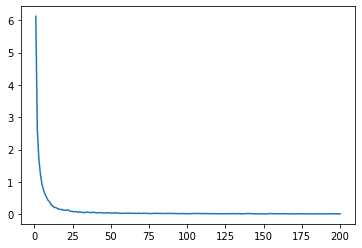

In [10]:
BATCH_SIZE=64 
LR=0.001
CLIP=5.
num_epochs = 200
train_dataset=I2B2DatasetReader('./datafiles/train.txt',dictionary(),dictionary(),training=True)
train_dataset.dic_word,word2emb=augment_vocab(train_dataset.dic_word,"datafiles/glove.6B.300d.txt",['./datafiles/dev.txt','./datafiles/test.txt'])
dev_dataset=I2B2DatasetReader('./datafiles/dev.txt',train_dataset.dic_word,train_dataset.dic_char)
test_dataset=I2B2DatasetReader('./datafiles/test.txt',train_dataset.dic_word,train_dataset.dic_char)

train_loader=DataLoader(train_dataset,BATCH_SIZE,shuffle=True,num_workers=2,collate_fn=collate_batch)
dev_loader=DataLoader(dev_dataset,BATCH_SIZE,shuffle=False,num_workers=2,collate_fn=collate_batch)
test_loader=DataLoader(test_dataset,BATCH_SIZE,shuffle=False,num_workers=2,collate_fn=collate_batch)

model = LSTM_CRF(word2emb,train_dataset.dic_word,train_dataset.dic_char).cuda()
optimizer=torch.optim.Adam(model.parameters(),LR)
precision_list = []
accuracy_list = []
recall_list = []
best_score=0
best_f1score_validation = 0
loss_vals=  []
loss_vals_validation =  []
for epoch in range(num_epochs):
    model.train()
    epoch_loss=[]
    pbar=tqdm(total=len(train_loader))
    for i,(word_num,word_ids,char_ids,label_ids) in enumerate(train_loader):
        loss=model(word_num.cuda(),word_ids.cuda(),char_ids.cuda(),label_ids.cuda())
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_norm_(lstm_crf.parameters(),CLIP)
        optimizer.step()
        epoch_loss.append(loss.item())
        pbar.update(1)
    pbar.close()
    loss_vals.append(sum(epoch_loss)/len(epoch_loss))
    mean_loss=torch.mean(torch.tensor(epoch_loss)).item()
   

    model.eval()
    f1_score=0

    
    #for loader in (test_loader):
    testloader=test_loader

    outputs=[]
    for i,(word_num,word_ids,char_ids,label_ids) in enumerate(testloader):
        word_num,word_ids,char_ids,label_ids=word_num.cuda(),word_ids.cuda(),char_ids.cuda(),label_ids.cuda()
        pred=model.decode(word_num,word_ids,char_ids)
        outputs+=list_batch(pred,word_num,word_ids,label_ids, train_dataset.dic_word, train_dataset.label_map)

    f=open('outputs.txt','w',encoding='utf-8')
    f.write('\n'.join(outputs))
    f.close()
    
    os.system("python -m conlleval outputs.txt > results")
    #os.system("./conlleval < outputs.txt > results")
    f=open('results','r',encoding='utf-8')
    
    elems = re.split('[:;]+', f.readlines()[1])
    f1_score=float(elems[7])
    # recall_list.append(elems[5])
    # precision_list.append(elems[3])
    # accuracy_list.append(elems[1])
    f.close()
    best_score=max(best_score,f1_score)
    #print('epoch %d:  mean accuracy: %.4f  mean precision: %.2f  mean recall: %.2f'%(epoch,mean_accuracy,mean_precision,mean_recall))

    print('epoch %d:  mean loss: %.4f  f1 score: %.2f  best: %.2f'%(epoch,mean_loss,f1_score,best_score))

my_plot(np.linspace(1, num_epochs, num_epochs).astype(int), loss_vals)  